# Breast Cancer Detection - CRISP-DM Project

## 1. Business Understanding

**Objective:** Predict malignant vs benign breast tumors from the provided dataset (data.csv).

**Success Criteria:** 
- High Recall for Malignant class (minimize false negatives)
- High ROC-AUC score

## 2. Data Understanding

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, accuracy_score, 
    recall_score, precision_score, f1_score, mean_squared_error
)
from imblearn.over_sampling import SMOTE

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense, Dropout
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

In [46]:
df = pd.read_csv('data.csv')
print('Dataset Shape:', df.shape)
display(df.head())
print(df.info())
print('Missing Values:', df.isna().sum().sum())
print('Target Distribution:', df['diagnosis'].value_counts())

Dataset Shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [47]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 2.1 Dataset Overview

In [48]:
print(f"Total missing values: {df.isnull().sum().sum()}")

Total missing values: 569


In [49]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 2.2 Feature Structure Analysis

The dataset contains **30 features** derived from **10 base measurements**, each with **3 statistical aggregations**:

- **Mean (_mean):** Average value across all cells in the image
- **Standard Error (_se):** Standard error of the mean (measurement variability)
- **Worst (_worst):** Largest (worst) value found among all cells

**Base Features (10):** radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal_dimension

**Why these statistics matter:**
- **Mean:** Captures typical/representative cell characteristics
- **SE:** Indicates consistency/variability (high SE = more heterogeneous tumor)
- **Worst:** Captures the most extreme/malignant characteristics (often most predictive)

> **Note:** We don't have raw pixel-level data - these are already aggregated statistics from image analysis.

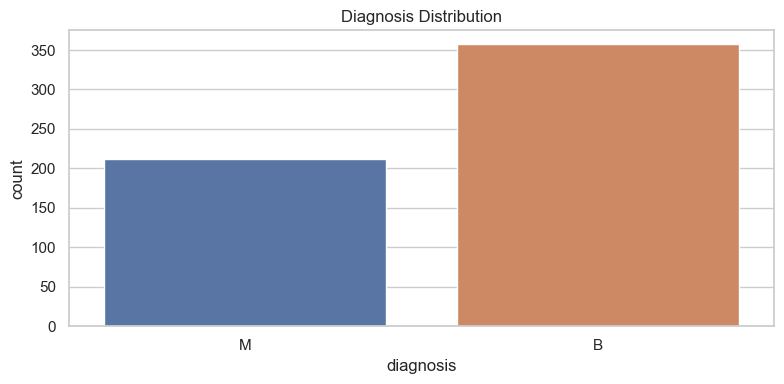

diagnosis
B    357
M    212
Name: count, dtype: int64


In [50]:
os.makedirs('results/plots', exist_ok=True)

plt.figure(figsize=(8, 4))
diagnosis_counts = df['diagnosis'].value_counts()
sns.countplot(x='diagnosis', data=df, hue='diagnosis', legend=False)
plt.title('Diagnosis Distribution')
plt.tight_layout()
# plt.savefig('results/plots/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(diagnosis_counts)

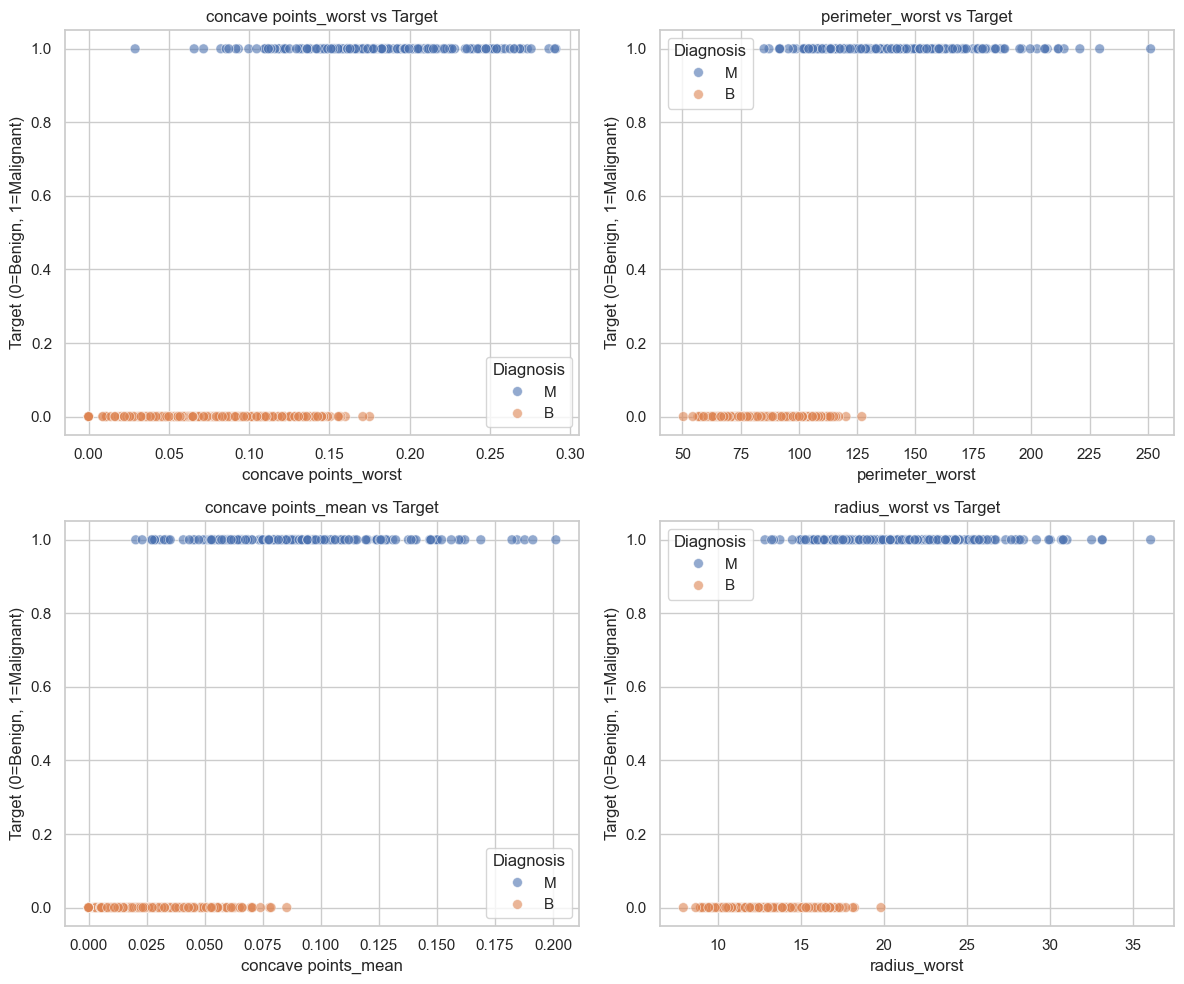

Features sélectionnées pour les scatter plots: ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst']


In [51]:

scatter_df = df.copy()

scatter_df['target'] = scatter_df['diagnosis'].map({'M': 1, 'B': 0})

top_features = scatter_df.select_dtypes(include=[np.number]).corr()['target'].abs().sort_values(ascending=False).head(6).index.tolist()

if 'target' in top_features:
    top_features.remove('target')

selected_features = top_features[:4]

# figsize=(12, 10) = taille de la figure en pouces (largeur=12, hauteur=10)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for idx, feature in enumerate(selected_features):
    ax = axes[idx]
    
    sns.scatterplot(x=feature, y='target', hue='diagnosis', data=scatter_df, ax=ax, alpha=0.6, s=50)
    
    ax.set_title(f'{feature} vs Target')
    
    ax.set_xlabel(feature)
    
    ax.set_ylabel('Target (0=Benign, 1=Malignant)')
    
    ax.legend(title='Diagnosis')

plt.tight_layout()

# plt.savefig('results/plots/feature_scatter_plots.png', dpi=150, bbox_inches='tight')

plt.show()

print(f"Features sélectionnées pour les scatter plots: {selected_features}")



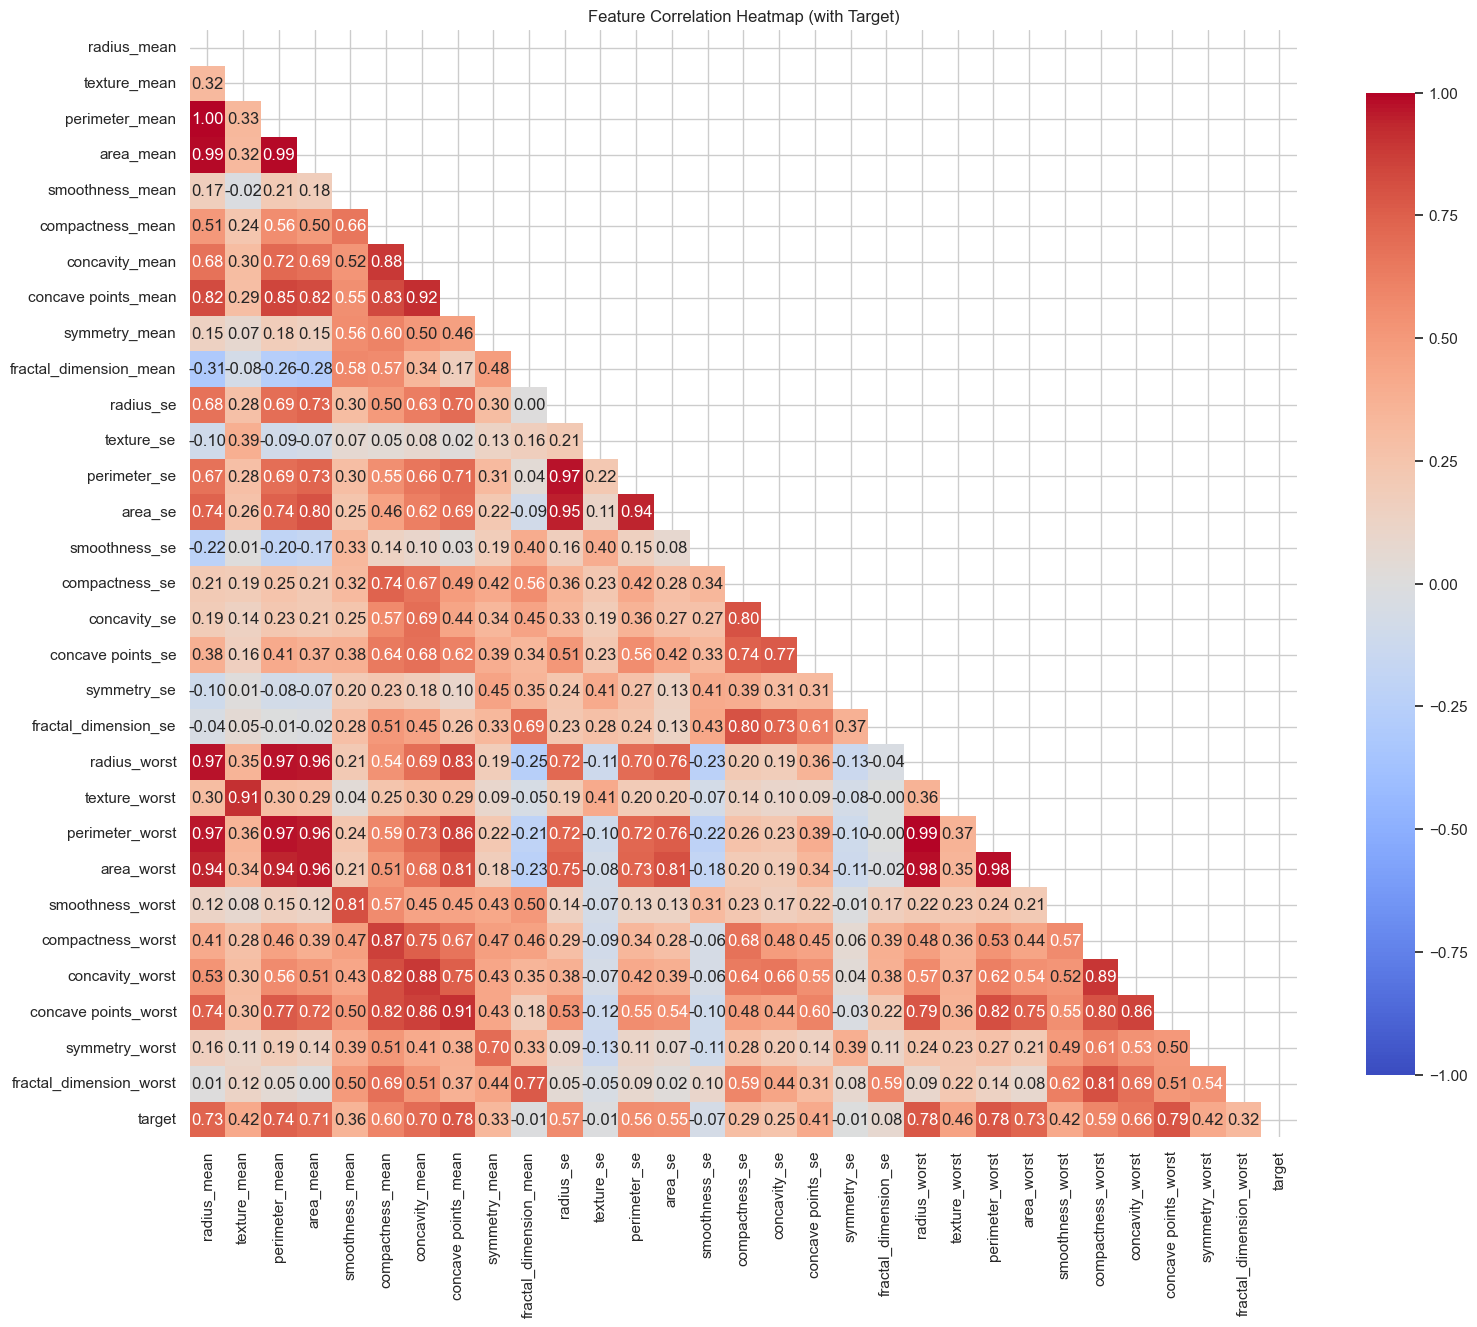

In [52]:
corr_df = df.copy()

corr_df['target'] = corr_df['diagnosis'].map({'M': 1, 'B': 0})

numeric_df = corr_df.select_dtypes(include=[np.number]).drop(['id','Unnamed: 32'], axis=1, errors='ignore')

corr_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# figsize=(16, 14) = taille de la figure en pouces (largeur=16, hauteur=14)
plt.figure(figsize=(16, 14))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap (with Target)')

plt.tight_layout()

# plt.savefig('results/plots/correlation_heatmap.png', dpi=150, bbox_inches='tight')

plt.show()

## 3. Data Preparation

### 3.1 Data Cleaning and Preprocessing

In [53]:
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

le = LabelEncoder()

df['diagnosis'] = le.fit_transform(df['diagnosis'])

X = df.drop('diagnosis', axis=1)

y = df['diagnosis']


print(f"  Benign (0): {np.bincount(y)[0]}")
print(f"  Malignant (1): {np.bincount(y)[1]}")
print(f"  Imbalance ratio: {np.bincount(y)[0] / np.bincount(y)[1]:.2f}:1")

smote = SMOTE(random_state=42, sampling_strategy=1.0)

X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\nClass distribution in full dataset (after SMOTE):")
print(f"  Benign (0): {np.bincount(y_balanced)[0]}")
print(f"  Malignant (1): {np.bincount(y_balanced)[1]}")
print(f"  Imbalance ratio: {np.bincount(y_balanced)[0] / np.bincount(y_balanced)[1]:.2f}:1")
print(f"  Total samples: {len(X_balanced)} (increased from {len(X)})")

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

os.makedirs('data_processed', exist_ok=True)

df.to_csv('data_processed/data_clean.csv', index=False)

print(f"\nTraining set: {X_train_scaled.shape[0]} samples (70%)")
print(f"Test set: {X_test_scaled.shape[0]} samples (30%)")

print(f"\nClass distribution in training set:")
print(f"  Benign (0): {np.bincount(y_train)[0]}")
print(f"  Malignant (1): {np.bincount(y_train)[1]}")
print(f"  Imbalance ratio: {np.bincount(y_train)[0] / np.bincount(y_train)[1]:.2f}:1")

print(f"\nClass distribution in test set:")
print(f"  Benign (0): {np.bincount(y_test)[0]}")
print(f"  Malignant (1): {np.bincount(y_test)[1]}")
print(f"  Imbalance ratio: {np.bincount(y_test)[0] / np.bincount(y_test)[1]:.2f}:1")


  Benign (0): 357
  Malignant (1): 212
  Imbalance ratio: 1.68:1

Class distribution in full dataset (after SMOTE):
  Benign (0): 357
  Malignant (1): 357
  Imbalance ratio: 1.00:1
  Total samples: 714 (increased from 569)

Training set: 499 samples (70%)
Test set: 215 samples (30%)

Class distribution in training set:
  Benign (0): 249
  Malignant (1): 250
  Imbalance ratio: 1.00:1

Class distribution in test set:
  Benign (0): 108
  Malignant (1): 107
  Imbalance ratio: 1.01:1


## 4. Modeling

We'll train and evaluate multiple models following the research paper:
- Linear Regression (as Classifier, Section 2.4.2) - uses Eq. 7, 8, 9
- Softmax Regression (multinomial logistic regression)
- Multi-Layer Perceptron (MLP)
- Support Vector Machine (SVM)
- K-Nearest Neighbors with L1 and L2 distances


### 4.1 Linear Regression (as Classifier)

According to the paper (Section 2.4.2), Linear Regression (Eq. 7) is used as a classifier by applying a threshold (Eq. 8) to the continuous output. The loss function is MSE (Eq. 9).

In [54]:
os.makedirs('results', exist_ok=True)



from sklearn.linear_model import SGDRegressor


# Modèle de régression linéaire (Eq. 7: y = θ·x + b)
# Ce modèle apprend les paramètres θ (weights) et b (bias) qui minimisent MSE (Eq. 9)
linear_model = SGDRegressor(loss='squared_error', learning_rate='constant', eta0=1e-3, 
                             max_iter=3000, random_state=42)

# Le modèle minimise MSE (Eq. 9) en utilisant SGD
linear_model.fit(X_train_scaled, y_train)

linear_y_test_continuous = linear_model.predict(X_test_scaled)

# Équation 8: 
threshold = 0.5

lr_y_test_pred = (linear_y_test_continuous >= threshold).astype(int)

from sklearn.preprocessing import MinMaxScaler
prob_scaler = MinMaxScaler()
linear_y_train_continuous = linear_model.predict(X_train_scaled)
prob_scaler.fit(linear_y_train_continuous.reshape(-1, 1))
lr_y_test_proba = prob_scaler.transform(linear_y_test_continuous.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_squared_error
mse_loss = mean_squared_error(y_test, linear_y_test_continuous)

lr_results = {
    # Score Accuracy sur l'ensemble de test (Test Accuracy dans le papier, Table 2)
    'Test_Accuracy': float(accuracy_score(y_test, lr_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, lr_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, lr_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, lr_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, lr_y_test_pred, pos_label=1)),
    # MSE Loss (Eq. 9) - Mean Squared Error
    'Test_MSE': float(mse_loss)
}

cm_lr = confusion_matrix(y_test, lr_y_test_pred)
tn, fp, fn, tp = cm_lr.ravel()  # True Negatives, False Positives, False Negatives, True Positives
specificity_lr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
lr_results['Test_Specificity'] = float(specificity_lr)

# 'w' = mode écriture (write)

print("Linear Regression (as Classifier) Results:")
print(f"  Model: y = θ·x + b (Eq. 7), Threshold = 0.5 (Eq. 8), Loss = MSE (Eq. 9)")
print(f"  Test Accuracy: {lr_results['Test_Accuracy']:.4f}")
print(f"  Test ROC-AUC: {lr_results['Test_ROC_AUC']:.4f}")
print(f"  Test Recall (Sensitivity): {lr_results['Test_Recall']:.4f}")
print(f"  Test MSE Loss (Eq. 9): {lr_results['Test_MSE']:.4f}")
print(f"  Test Specificity (TNR): {lr_results['Test_Specificity']:.4f}")


Linear Regression (as Classifier) Results:
  Model: y = θ·x + b (Eq. 7), Threshold = 0.5 (Eq. 8), Loss = MSE (Eq. 9)
  Test Accuracy: 0.9535
  Test ROC-AUC: 0.9971
  Test Recall (Sensitivity): 0.9065
  Test MSE Loss (Eq. 9): 0.0652
  Test Specificity (TNR): 1.0000


### 4.2 Softmax Regression

In [55]:

# eta0=1e-3 = taux d'apprentissage initial de 0.001 (comme dans le papier, Table 1: learning_rate=1e-3)
# max_iter=3000 = nombre maximum d'itérations pour la convergence (comme dans le papier, Table 1)
softmax_model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=1e-3, max_iter=3000, 
                               class_weight='balanced', random_state=42)

softmax_model.fit(X_train_scaled, y_train)

softmax_y_test_proba = softmax_model.predict_proba(X_test_scaled)[:, 1]

softmax_y_test_pred = softmax_model.predict(X_test_scaled)

softmax_results = {
    'Test_Accuracy': float(accuracy_score(y_test, softmax_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, softmax_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, softmax_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, softmax_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, softmax_y_test_pred, pos_label=1))
}

# 'w' = mode écriture (write)

print("Softmax Regression Results:")
print(f"  Test Accuracy: {softmax_results['Test_Accuracy']:.4f}")
print(f"  Test ROC-AUC: {softmax_results['Test_ROC_AUC']:.4f}")
print(f"  Test Recall (Sensitivity): {softmax_results['Test_Recall']:.4f}")


Softmax Regression Results:
  Test Accuracy: 0.9581
  Test ROC-AUC: 0.9978
  Test Recall (Sensitivity): 0.9159


### 4.3 Multi-Layer Perceptron (MLP)

In [66]:

mlp_model = MLPClassifier(
    hidden_layer_sizes=(500, 500, 500),
    learning_rate_init=1e-2,
    alpha=0.01,
    max_iter=3000,
    early_stopping=True,
    #       leading to 100% training accuracy but lower test accuracy
    random_state=42,
    verbose=1,
    validation_fraction=0.1
)

mlp_model.fit(X_train_scaled, y_train)

mlp_y_test_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]

mlp_y_test_pred = mlp_model.predict(X_test_scaled)

mlp_results = {
    'Test_Accuracy': float(accuracy_score(y_test, mlp_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, mlp_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, mlp_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, mlp_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, mlp_y_test_pred, pos_label=1))
}

# 'w' = mode écriture (write)

print("MLP Results:")
print(f"  Test Accuracy: {mlp_results['Test_Accuracy']:.4f}")
print(f"  Test ROC-AUC: {mlp_results['Test_ROC_AUC']:.4f}")
print(f"  Test Recall (Sensitivity): {mlp_results['Test_Recall']:.4f}")


Iteration 1, loss = 1.15388148
Validation score: 0.920000
Iteration 2, loss = 0.24215505
Validation score: 0.860000
Iteration 3, loss = 0.28222649
Validation score: 0.960000
Iteration 4, loss = 0.11624442
Validation score: 0.940000
Iteration 5, loss = 0.11386797
Validation score: 0.940000
Iteration 6, loss = 0.10205679
Validation score: 0.960000
Iteration 7, loss = 0.09806018
Validation score: 0.960000
Iteration 8, loss = 0.09614079
Validation score: 0.960000
Iteration 9, loss = 0.09208727
Validation score: 0.940000
Iteration 10, loss = 0.08813627
Validation score: 0.940000
Iteration 11, loss = 0.07479278
Validation score: 0.940000
Iteration 12, loss = 0.07040450
Validation score: 0.940000
Iteration 13, loss = 0.06486381
Validation score: 0.940000
Iteration 14, loss = 0.05915534
Validation score: 0.920000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP Results:
  Test Accuracy: 0.9581
  Test ROC-AUC: 0.9972
  Test Recall (Sensitivity): 0

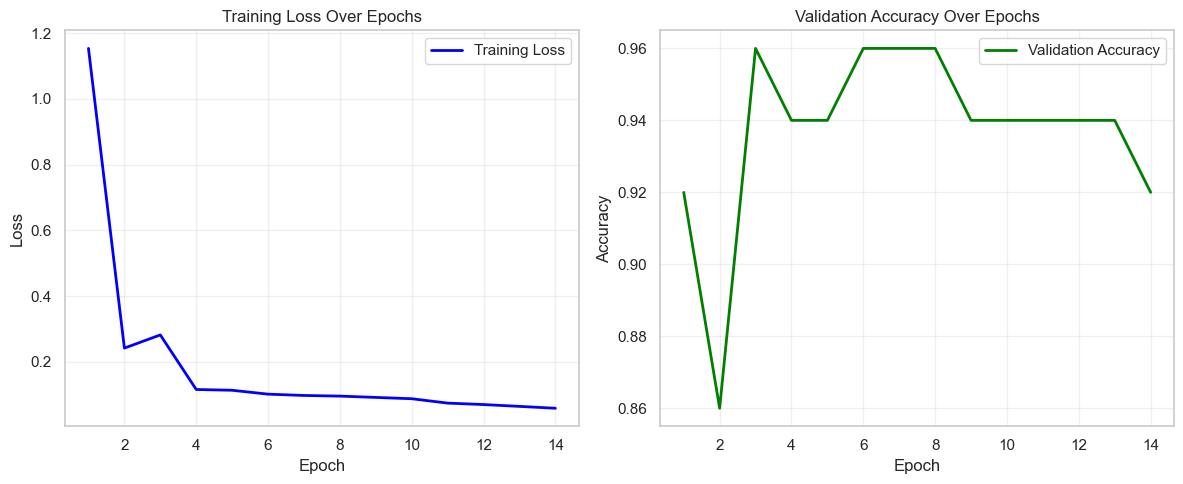

In [ ]:

if hasattr(mlp_model, 'loss_curve_'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    epochs = range(1, len(mlp_model.loss_curve_) + 1)
    
    ax1.plot(epochs, mlp_model.loss_curve_, label='Training Loss', linewidth=2, color='blue')
    
    ax1.set_xlabel('Epoch')
    
    ax1.set_ylabel('Loss')
    
    ax1.set_title('Training Loss Over Epochs')
    
    # Adjust y-axis scale for loss - start from 0 and add some padding at the top
    loss_min = min(mlp_model.loss_curve_)
    loss_max = max(mlp_model.loss_curve_)
    ax1.set_ylim([0, loss_max * 1.1])
    
    ax1.legend()
    
    ax1.grid(True, alpha=0.3)
    
    if hasattr(mlp_model, 'validation_scores_') and mlp_model.validation_scores_ is not None and len(mlp_model.validation_scores_) > 0:
        ax2.plot(epochs, mlp_model.validation_scores_, label='Validation Accuracy', linewidth=2, color='green')
        
        # 'Epoch' = texte du label
        ax2.set_xlabel('Epoch')
        
        # 'Accuracy' = texte du label
        ax2.set_ylabel('Accuracy')
        
        ax2.set_title('Validation Accuracy Over Epochs')
        
        # Adjust y-axis scale for accuracy - focus on the relevant range (0.8 to 1.0)
        acc_min = min(mlp_model.validation_scores_)
        acc_max = max(mlp_model.validation_scores_)
        ax2.set_ylim([max(0.75, acc_min - 0.05), min(1.0, acc_max + 0.02)])
        
        ax2.legend()
        
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Validation scores not available.\nUse validation_fraction > 0.', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Validation Accuracy Over Epochs')
    
    plt.tight_layout()
    
# plt.savefig('results/plots/mlp_training_curves.png', dpi=150, bbox_inches='tight')
    
    plt.show()
    
else:
    print("Le modèle MLP n'a pas d'historique d'entraînement disponible (loss_curve_).")



### 4.4 Support Vector Machine (SVM)

In [58]:

svm_model = SVC(
    C=5,
    kernel='rbf',
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42,
    verbose=0,
    max_iter=3000
)

svm_model.fit(X_train_scaled, y_train)

svm_y_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_y_test_pred = svm_model.predict(X_test_scaled)

svm_results = {
    'Test_Accuracy': float(accuracy_score(y_test, svm_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, svm_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, svm_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, svm_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, svm_y_test_pred, pos_label=1))
}

# 'w' = mode écriture (write)

print("SVM Results:")
print(f"  Test Accuracy: {svm_results['Test_Accuracy']:.4f}")
print(f"  Test ROC-AUC: {svm_results['Test_ROC_AUC']:.4f}")
print(f"  Test Recall (Sensitivity): {svm_results['Test_Recall']:.4f}")


SVM Results:
  Test Accuracy: 0.9674
  Test ROC-AUC: 0.9976
  Test Recall (Sensitivity): 0.9346


### 4.5 K-Nearest Neighbors (KNN)

In [59]:
from sklearn.neighbors import KNeighborsClassifier


knn_l1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='minkowski', p=1, n_jobs=-1)
    #       which results in 100% training accuracy (expected behavior, not a bug)

knn_l1.fit(X_train_scaled, y_train)

knn_l1_y_test_pred = knn_l1.predict(X_test_scaled)

knn_l1_y_test_proba = knn_l1.predict_proba(X_test_scaled)[:, 1]

knn_l1_results = {
    'Test_Accuracy': float(accuracy_score(y_test, knn_l1_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, knn_l1_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, knn_l1_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, knn_l1_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, knn_l1_y_test_pred, pos_label=1))
}


knn_l2 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='minkowski', p=2, n_jobs=-1)
    #       which results in 100% training accuracy (expected behavior, not a bug)

knn_l2.fit(X_train_scaled, y_train)

knn_l2_y_test_pred = knn_l2.predict(X_test_scaled)

knn_l2_y_test_proba = knn_l2.predict_proba(X_test_scaled)[:, 1]

knn_l2_results = {
    'Test_Accuracy': float(accuracy_score(y_test, knn_l2_y_test_pred)),
    'Test_ROC_AUC': float(roc_auc_score(y_test, knn_l2_y_test_proba)),
    'Test_Recall': float(recall_score(y_test, knn_l2_y_test_pred, pos_label=1)),
    'Test_Precision': float(precision_score(y_test, knn_l2_y_test_pred, pos_label=1)),
    'Test_F1': float(f1_score(y_test, knn_l2_y_test_pred, pos_label=1))
}

# 'w' = mode écriture


### 4.6 GRU-SVM (Section 2.4.1 - Proposed Model)

**GRU-SVM** est le modèle proposé par les auteurs du papier. Il combine:
- **GRU (Gated Recurrent Unit)**: Pour extraire des caractéristiques séquentielles
- **SVM (Support Vector Machine)**: Pour la classification finale

Architecture:
1. Les features sont transformées en séquence pour le GRU
2. Le GRU extrait des représentations de haut niveau
3. Les features extraites sont utilisées par un SVM pour la classification


In [60]:
if TENSORFLOW_AVAILABLE:
    
    n_features = X_train_scaled.shape[1]
    
    X_train_gru = X_train_scaled.reshape(X_train_scaled.shape[0], n_features, 1)
    X_test_gru = X_test_scaled.reshape(X_test_scaled.shape[0], n_features, 1)
    
    gru_model = Sequential([
        GRU(64, return_sequences=False, input_shape=(n_features, 1)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = gru_model.fit(
        X_train_gru, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    from tensorflow.keras.models import Model
    # Fix: Access input via first layer (works in all Keras versions)
    model_input = gru_model.layers[0].input
    feature_extractor = Model(inputs=model_input, outputs=gru_model.layers[-3].output)
    
    print("  Extracting features with GRU...")
    gru_train_features = feature_extractor.predict(X_train_gru, verbose=0)
    gru_test_features = feature_extractor.predict(X_test_gru, verbose=0)
    
    gru_svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    gru_svm_model.fit(gru_train_features, y_train)
    
    gru_svm_y_test_pred = gru_svm_model.predict(gru_test_features)
    gru_svm_y_test_proba = gru_svm_model.predict_proba(gru_test_features)[:, 1]
    
    gru_svm_results = {
        'Test_Accuracy': float(accuracy_score(y_test, gru_svm_y_test_pred)),
        'Test_ROC_AUC': float(roc_auc_score(y_test, gru_svm_y_test_proba)),
        'Test_Recall': float(recall_score(y_test, gru_svm_y_test_pred, pos_label=1)),
        'Test_Precision': float(precision_score(y_test, gru_svm_y_test_pred, pos_label=1)),
        'Test_F1': float(f1_score(y_test, gru_svm_y_test_pred, pos_label=1))
    }
    
    cm_gru_svm = confusion_matrix(y_test, gru_svm_y_test_pred)
    tn_gru_svm, fp_gru_svm, fn_gru_svm, tp_gru_svm = cm_gru_svm.ravel()
    specificity_gru_svm = tn_gru_svm / (tn_gru_svm + fp_gru_svm) if (tn_gru_svm + fp_gru_svm) > 0 else 0.0
    gru_svm_results['Test_Specificity'] = float(specificity_gru_svm)
    
    
    print("\nGRU-SVM Results:")
    print(f"  Test Accuracy: {gru_svm_results['Test_Accuracy']:.4f}")
    print(f"  Test ROC-AUC: {gru_svm_results['Test_ROC_AUC']:.4f}")
    print(f"  Test Recall (Sensitivity): {gru_svm_results['Test_Recall']:.4f}")
    print(f"  Test Precision: {gru_svm_results['Test_Precision']:.4f}")
    print(f"  Test F1-Score: {gru_svm_results['Test_F1']:.4f}")
    print(f"  Test Specificity (TNR): {gru_svm_results['Test_Specificity']:.4f}")
    
else:
    gru_svm_results = None
    gru_svm_model = None


c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Extracting features with GRU...

GRU-SVM Results:
  Test Accuracy: 0.9628
  Test ROC-AUC: 0.9888
  Test Recall (Sensitivity): 0.9346
  Test Precision: 0.9901
  Test F1-Score: 0.9615
  Test Specificity (TNR): 0.9907


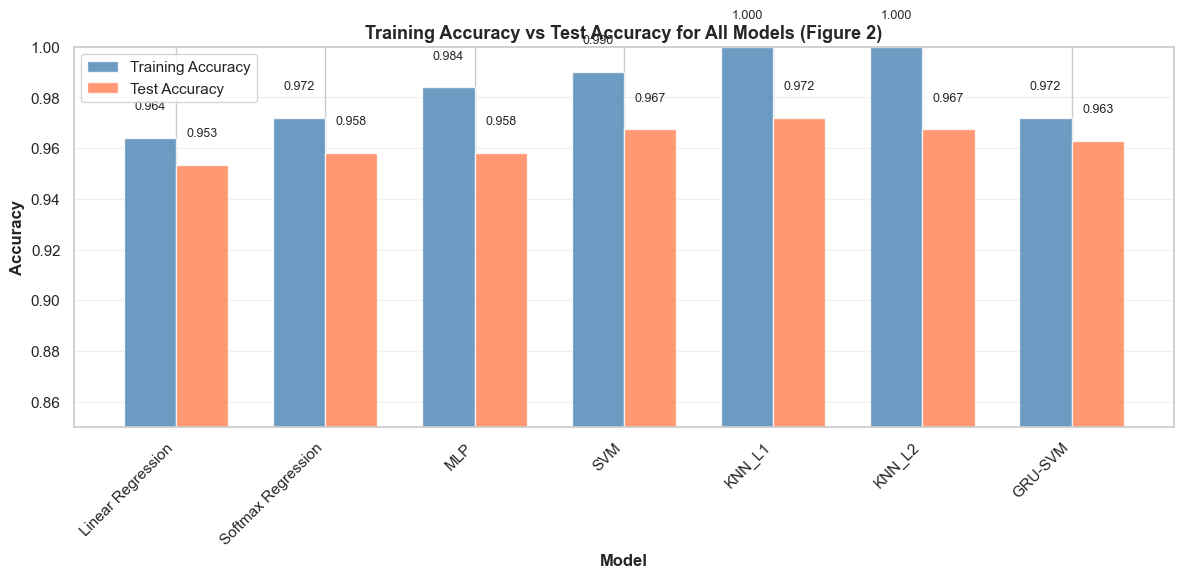

In [61]:

# ===== TRAINING ACCURACY PLOT FOR ALL MODELS (Figure 2 in paper) =====

# Calculate training accuracies for all models
# Linear Regression
linear_y_train_pred = (linear_model.predict(X_train_scaled) > 0.5).astype(int)
lr_train_score = accuracy_score(y_train, linear_y_train_pred)

# Softmax Regression
softmax_y_train_pred = softmax_model.predict(X_train_scaled)
softmax_train_score = accuracy_score(y_train, softmax_y_train_pred)

# MLP
mlp_y_train_pred = mlp_model.predict(X_train_scaled)
mlp_train_score = accuracy_score(y_train, mlp_y_train_pred)

# SVM
svm_y_train_pred = svm_model.predict(X_train_scaled)
svm_train_score = accuracy_score(y_train, svm_y_train_pred)

# KNN L1
knn_l1_y_train_pred = knn_l1.predict(X_train_scaled)
knn_l1_train_score = accuracy_score(y_train, knn_l1_y_train_pred)

# KNN L2
knn_l2_y_train_pred = knn_l2.predict(X_train_scaled)
knn_l2_train_score = accuracy_score(y_train, knn_l2_y_train_pred)

model_names = ['Linear Regression', 'Softmax Regression', 'MLP', 'SVM', 'KNN_L1', 'KNN_L2']
train_accuracies = [
    lr_train_score,
    softmax_train_score,
    mlp_train_score,
    svm_train_score,
    knn_l1_train_score,
    knn_l2_train_score
]
test_accuracies = [
    lr_results['Test_Accuracy'],
    softmax_results['Test_Accuracy'],
    mlp_results['Test_Accuracy'],
    svm_results['Test_Accuracy'],
    knn_l1_results['Test_Accuracy'],
    knn_l2_results['Test_Accuracy']
]

if TENSORFLOW_AVAILABLE and gru_svm_results is not None:
    gru_svm_y_train_pred = gru_svm_model.predict(gru_train_features)
    gru_svm_train_score = accuracy_score(y_train, gru_svm_y_train_pred)
    model_names.append('GRU-SVM')
    train_accuracies.append(gru_svm_train_score)
    test_accuracies.append(gru_svm_results['Test_Accuracy'])

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_names))
width = 0.35  # Largeur des barres

bars1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='coral', alpha=0.8)

for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies)):
    ax.text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Training Accuracy vs Test Accuracy for All Models (Figure 2)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim([0.85, 1.0])
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# plt.savefig('results/plots/training_accuracy_all_models.png', dpi=150, bbox_inches='tight')
plt.show()



## 5. Evaluation

### 5.1 Model Evaluation on Test Set

In [62]:
test_results = {}

# dans la section d'entraînement du modèle (cellule précédente)

cm_lr = confusion_matrix(y_test, lr_y_test_pred)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
specificity_lr = tn_lr / (tn_lr + fp_lr) if (tn_lr + fp_lr) > 0 else 0.0

test_results['Linear Regression'] = {
    'accuracy': float(accuracy_score(y_test, lr_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, lr_y_test_proba)),
    'recall': float(recall_score(y_test, lr_y_test_pred, pos_label=1)),
    # Score Precision (précision)
    'precision': float(precision_score(y_test, lr_y_test_pred, pos_label=1)),   
    'f1_score': float(f1_score(y_test, lr_y_test_pred, pos_label=1)),
    'specificity': float(specificity_lr)
}

softmax_y_test_proba = softmax_model.predict_proba(X_test_scaled)[:, 1]
softmax_y_test_pred = softmax_model.predict(X_test_scaled)
cm_softmax = confusion_matrix(y_test, softmax_y_test_pred)
tn_softmax, fp_softmax, fn_softmax, tp_softmax = cm_softmax.ravel()
specificity_softmax = tn_softmax / (tn_softmax + fp_softmax) if (tn_softmax + fp_softmax) > 0 else 0.0

test_results['Softmax Regression'] = {
    'accuracy': float(accuracy_score(y_test, softmax_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, softmax_y_test_proba)),
    'recall': float(recall_score(y_test, softmax_y_test_pred, pos_label=1)),    
    'precision': float(precision_score(y_test, softmax_y_test_pred, pos_label=1)),                                                                              
    'f1_score': float(f1_score(y_test, softmax_y_test_pred, pos_label=1)),
    'specificity': float(specificity_softmax)
}

mlp_y_test_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]
mlp_y_test_pred = mlp_model.predict(X_test_scaled)
cm_mlp = confusion_matrix(y_test, mlp_y_test_pred)
tn_mlp, fp_mlp, fn_mlp, tp_mlp = cm_mlp.ravel()
specificity_mlp = tn_mlp / (tn_mlp + fp_mlp) if (tn_mlp + fp_mlp) > 0 else 0.0

test_results['MLP'] = {
    'accuracy': float(accuracy_score(y_test, mlp_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, mlp_y_test_proba)),
    'recall': float(recall_score(y_test, mlp_y_test_pred, pos_label=1)),        
    'precision': float(precision_score(y_test, mlp_y_test_pred, pos_label=1)),  
    'f1_score': float(f1_score(y_test, mlp_y_test_pred, pos_label=1)),
    'specificity': float(specificity_mlp)
}

svm_y_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
svm_y_test_pred = svm_model.predict(X_test_scaled)
cm_svm = confusion_matrix(y_test, svm_y_test_pred)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
specificity_svm = tn_svm / (tn_svm + fp_svm) if (tn_svm + fp_svm) > 0 else 0.0

test_results['SVM'] = {
    'accuracy': float(accuracy_score(y_test, svm_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, svm_y_test_proba)),
    'recall': float(recall_score(y_test, svm_y_test_pred, pos_label=1)),        
    'precision': float(precision_score(y_test, svm_y_test_pred, pos_label=1)),  
    'f1_score': float(f1_score(y_test, svm_y_test_pred, pos_label=1)),
    'specificity': float(specificity_svm)
}

knn_l1_y_test_proba = knn_l1.predict_proba(X_test_scaled)[:, 1]
knn_l1_y_test_pred = knn_l1.predict(X_test_scaled)
cm_knn_l1 = confusion_matrix(y_test, knn_l1_y_test_pred)
tn_knn_l1, fp_knn_l1, fn_knn_l1, tp_knn_l1 = cm_knn_l1.ravel()
specificity_knn_l1 = tn_knn_l1 / (tn_knn_l1 + fp_knn_l1) if (tn_knn_l1 + fp_knn_l1) > 0 else 0.0

test_results['KNN_L1'] = {
    'accuracy': float(accuracy_score(y_test, knn_l1_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, knn_l1_y_test_proba)),
    'recall': float(recall_score(y_test, knn_l1_y_test_pred, pos_label=1)),
    'precision': float(precision_score(y_test, knn_l1_y_test_pred, pos_label=1)),
    'f1_score': float(f1_score(y_test, knn_l1_y_test_pred, pos_label=1)),
    'specificity': float(specificity_knn_l1)
}

knn_l2_y_test_proba = knn_l2.predict_proba(X_test_scaled)[:, 1]
knn_l2_y_test_pred = knn_l2.predict(X_test_scaled)
cm_knn_l2 = confusion_matrix(y_test, knn_l2_y_test_pred)
tn_knn_l2, fp_knn_l2, fn_knn_l2, tp_knn_l2 = cm_knn_l2.ravel()
specificity_knn_l2 = tn_knn_l2 / (tn_knn_l2 + fp_knn_l2) if (tn_knn_l2 + fp_knn_l2) > 0 else 0.0

test_results['KNN_L2'] = {
    'accuracy': float(accuracy_score(y_test, knn_l2_y_test_pred)),
    'roc_auc': float(roc_auc_score(y_test, knn_l2_y_test_proba)),
    'recall': float(recall_score(y_test, knn_l2_y_test_pred, pos_label=1)),
    'precision': float(precision_score(y_test, knn_l2_y_test_pred, pos_label=1)),
    'f1_score': float(f1_score(y_test, knn_l2_y_test_pred, pos_label=1)),
    'specificity': float(specificity_knn_l2)
}

for k, v in test_results['Linear Regression'].items():
    lr_results[f'Test_{k}'] = v

for k, v in test_results['Softmax Regression'].items():
    softmax_results[f'Test_{k}'] = v

for k, v in test_results['MLP'].items():
    mlp_results[f'Test_{k}'] = v

for k, v in test_results['SVM'].items():
    svm_results[f'Test_{k}'] = v

for k, v in test_results['KNN_L1'].items():
    knn_l1_results[f'Test_{k}'] = v

for k, v in test_results['KNN_L2'].items():
    knn_l2_results[f'Test_{k}'] = v

if TENSORFLOW_AVAILABLE and gru_svm_results is not None:
    test_results['GRU-SVM'] = {
        'accuracy': gru_svm_results['Test_Accuracy'],
        'roc_auc': gru_svm_results['Test_ROC_AUC'],
        'recall': gru_svm_results['Test_Recall'],
        'precision': gru_svm_results['Test_Precision'],
        'f1_score': gru_svm_results['Test_F1'],
        'specificity': gru_svm_results['Test_Specificity']
    }



### 5.2 Confusion Matrix and ROC Curves

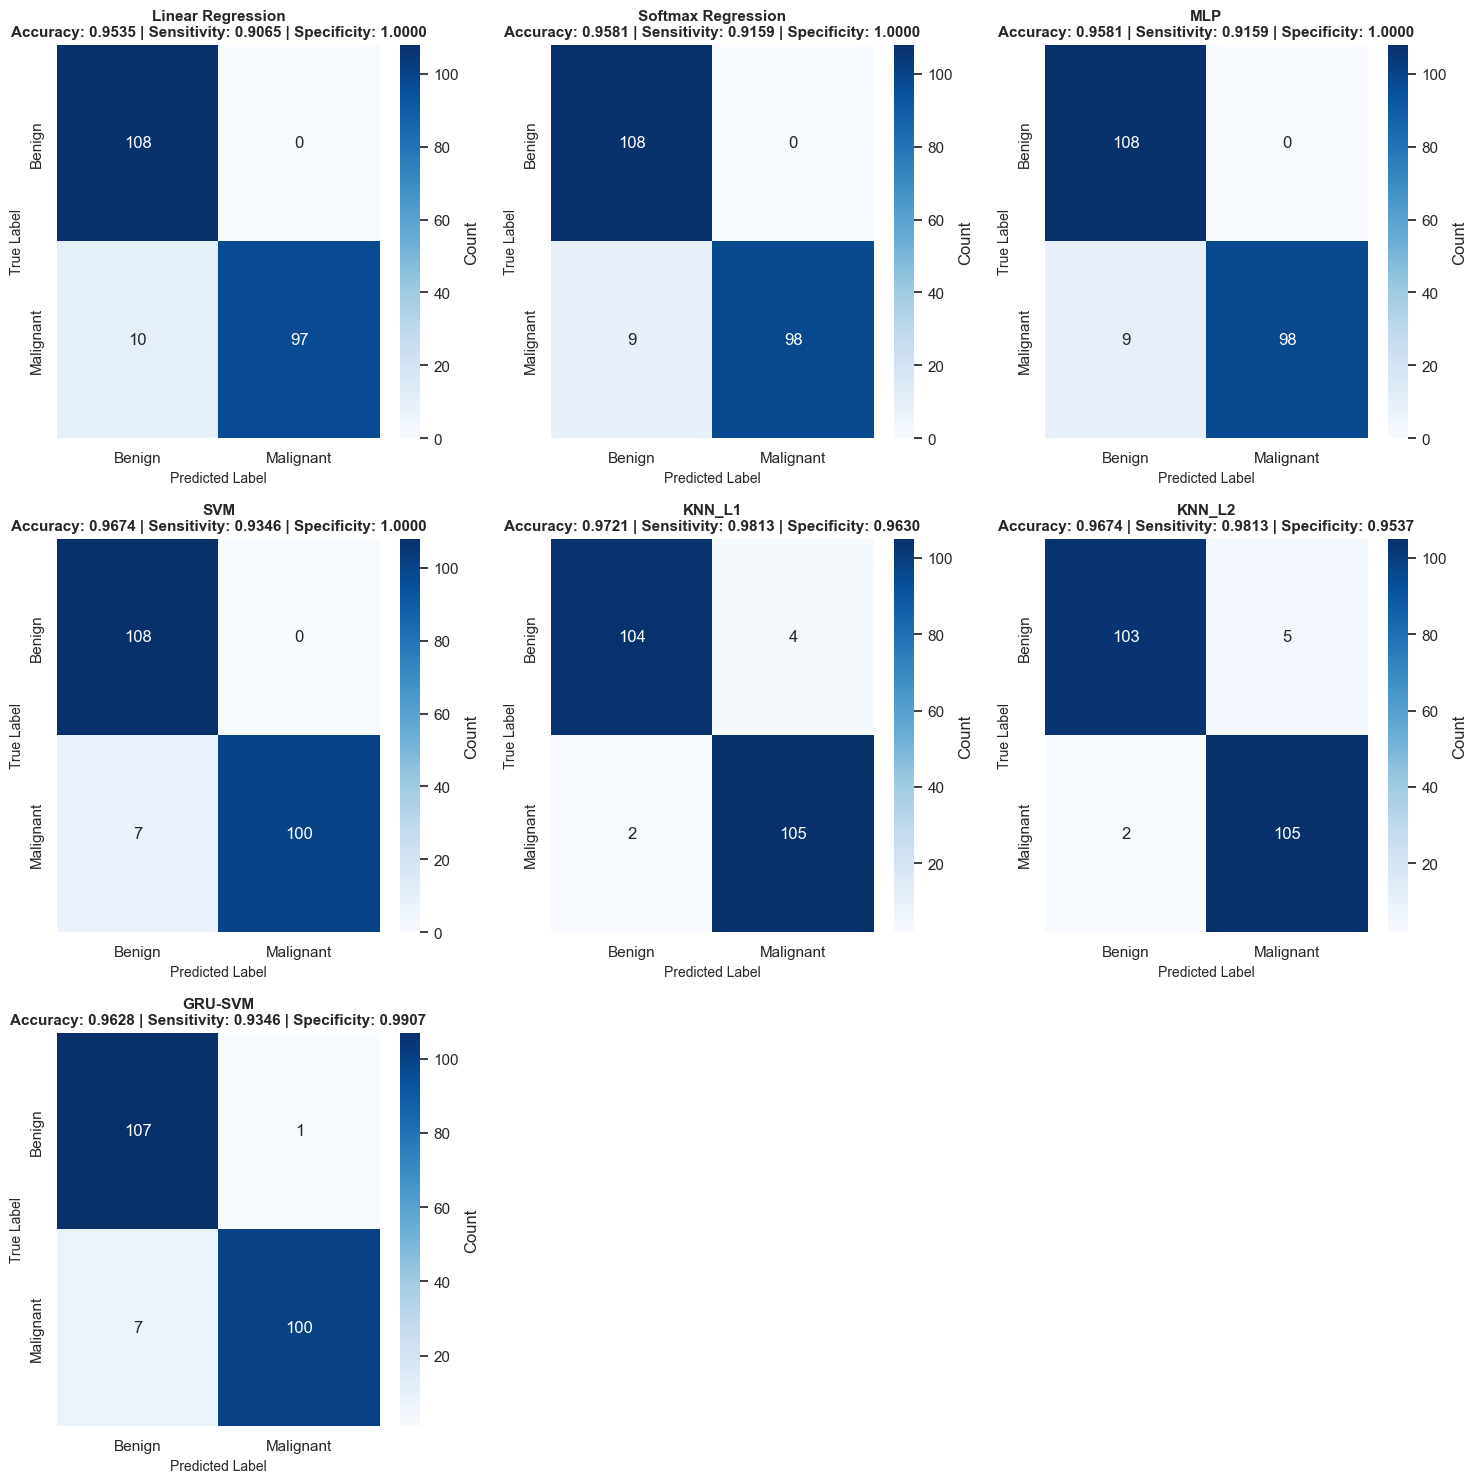

In [63]:
# ===== INDIVIDUAL CONFUSION MATRICES FOR ALL MODELS =====

# Prepare predictions and confusion matrices for all models
models_confusion_data = [
    ('Linear Regression', lr_y_test_pred, lr_y_test_proba),
    ('Softmax Regression', softmax_y_test_pred, softmax_y_test_proba),
    ('MLP', mlp_y_test_pred, mlp_y_test_proba),
    ('SVM', svm_y_test_pred, svm_y_test_proba),
    ('KNN_L1', knn_l1_y_test_pred, knn_l1_y_test_proba),
    ('KNN_L2', knn_l2_y_test_pred, knn_l2_y_test_proba)
]

# Add GRU-SVM if available
if TENSORFLOW_AVAILABLE and gru_svm_results is not None:
    models_confusion_data.append(('GRU-SVM', gru_svm_y_test_pred, gru_svm_y_test_proba))

# Calculate number of rows and columns for subplot grid
n_models = len(models_confusion_data)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_models == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes if isinstance(axes, np.ndarray) else [axes]
else:
    axes = axes.flatten()

# Plot confusion matrix for each model
for idx, (model_name, y_pred, y_proba) in enumerate(models_confusion_data):
    ax = axes[idx]
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Benign', 'Malignant'], 
                yticklabels=['Benign', 'Malignant'],
                cbar_kws={'label': 'Count'})
    
    # Set title with metrics
    title = f'{model_name}\nAccuracy: {accuracy:.4f} | Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
# plt.savefig('results/plots/confusion_matrix_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

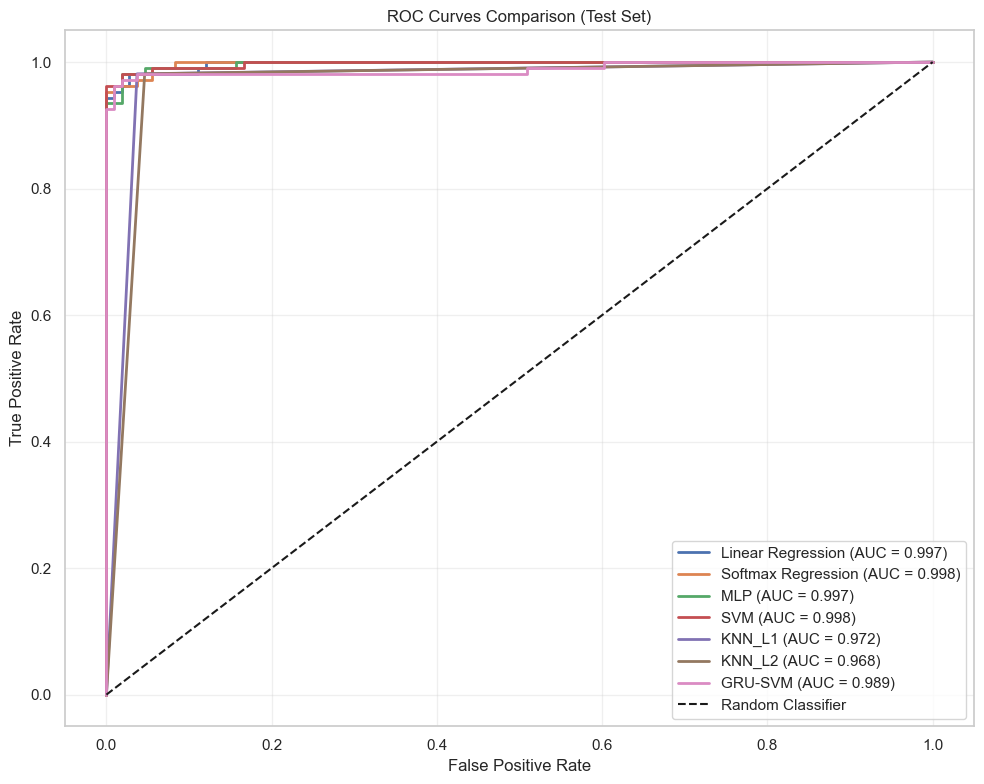

In [64]:
# figsize=(10, 8) = taille de la figure en pouces (largeur=10, hauteur=8)
plt.figure(figsize=(10, 8))

models_to_plot = [
    (None, 'Linear Regression', test_results['Linear Regression']['roc_auc']),
    (softmax_model, 'Softmax Regression', test_results['Softmax Regression']['roc_auc']),
    (mlp_model, 'MLP', test_results['MLP']['roc_auc']),
    (svm_model, 'SVM', test_results['SVM']['roc_auc']),
    (knn_l1, 'KNN_L1', test_results['KNN_L1']['roc_auc']),
    (knn_l2, 'KNN_L2', test_results['KNN_L2']['roc_auc'])
]

if TENSORFLOW_AVAILABLE and 'GRU-SVM' in test_results:
    models_to_plot.append((None, 'GRU-SVM', test_results['GRU-SVM']['roc_auc']))

for model, name, auc in models_to_plot:
    if model is None and name == 'Linear Regression':
        y_proba = lr_y_test_proba
    elif model is None and name == 'GRU-SVM':
        y_proba = gru_svm_y_test_proba
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curves Comparison (Test Set)')

plt.legend()

# grid(True) active la grille
plt.grid(True, alpha=0.3)

plt.tight_layout()

# plt.savefig('results/plots/roc_curves.png', dpi=150, bbox_inches='tight')

plt.show()


In [65]:
comparison_data = {
    'Linear Regression': {
        'Test_ROC_AUC': f"{test_results['Linear Regression']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['Linear Regression']['recall']:.4f}"
    },
    'Softmax Regression': {
        'Test_ROC_AUC': f"{test_results['Softmax Regression']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['Softmax Regression']['recall']:.4f}"
    },
    # Données pour MLP
    'MLP': {
        'Test_ROC_AUC': f"{test_results['MLP']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['MLP']['recall']:.4f}"
    },
    # Données pour SVM
    'SVM': {
        'Test_ROC_AUC': f"{test_results['SVM']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['SVM']['recall']:.4f}"
    },
    'KNN_L1': {
        'Test_ROC_AUC': f"{test_results['KNN_L1']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['KNN_L1']['recall']:.4f}"
    },
    'KNN_L2': {
        'Test_ROC_AUC': f"{test_results['KNN_L2']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['KNN_L2']['recall']:.4f}"
    }
}

if TENSORFLOW_AVAILABLE and 'GRU-SVM' in test_results:
    comparison_data['GRU-SVM'] = {
        'Test_ROC_AUC': f"{test_results['GRU-SVM']['roc_auc']:.4f}",
        'Test_Recall': f"{test_results['GRU-SVM']['recall']:.4f}"
    }

